In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Step 0: Read the train dataset and get a general idea on how it looks like

In [2]:
df = pd.read_csv('Data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Step 1: Understand the general profile of this dataset and how consistently populated are its features

In [3]:
#profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
#profile.to_file('RawDataProfile.html')

In [4]:
# There are many blanks in the 'Age' and in the 'Cabin' columns - Populating these features would be a bit troublesome - Discarding is an option for the Cabin column, since the amount of nulls is significantly higher

# Step 2: Feature Engineering - Curating and adding new features from the raw data

In [5]:
# Adding two new features: Family and Entitlement

In [6]:
df['Family'] = df['Name'].str.split(',').str.get(0)
df['Entitlement'] = df['Name'].str.split(',').str.get(1).str.split(' ').str.get(1)

In [7]:
df['Entitlement'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.', 'the',
       'Jonkheer.'], dtype=object)

In [8]:
# Trying to get an idea of how many people there are in each family
df[['Family', 'Name']].groupby('Family').size().reset_index(name='FamilySize').sort_values(by=['FamilySize'], ascending=False).head()

,Family,FamilySize
16,Andersson,9
532,Sage,7
563,Skoog,6
100,Carter,6
220,Goodwin,6


In [9]:
# Trying to get an idea of how many people there are by entitlement
df[['Entitlement', 'Name']].groupby('Entitlement').size().reset_index(name='qt').sort_values(by=['qt'], ascending=False).head()

,Entitlement,qt
11,Mr.,517
8,Miss.,182
12,Mrs.,125
7,Master.,40
3,Dr.,7


In [10]:
# Trying to get an idea of how many people survived in each family
df['Survived'] = df['Survived'].astype('int32')
df[['Family', 'Survived']].groupby('Family').sum().reset_index().sort_values(by=['Survived'], ascending=False).head()

,Family,Survived
100,Carter,4
32,Baclini,4
292,Johnson,3
306,Kelly,3
239,Harper,3


In [11]:
# Trying to get an idea of how many people survived by each entitlement
df[['Entitlement', 'Survived']].groupby('Entitlement').sum().reset_index().sort_values(by=['Survived'], ascending=False).head()

,Entitlement,Survived
8,Miss.,127
12,Mrs.,99
11,Mr.,81
7,Master.,23
3,Dr.,3


In [12]:
# Idea: add a column named 'FamilySize' to the original dataframe
df_family = df[['Family', 'Name']].groupby('Family').size().reset_index(name='FamilySize')
df = pd.merge(df, df_family, on='Family', how='left')

In [13]:
# Removing the 'Name' and the 'Family' columns now as they became unnecessary
df.drop('Name', axis=1, inplace=True)
df.drop('Family', axis=1, inplace=True)

In [14]:
# Trying to understand the different types of families
df[['SibSp', 'Parch', 'FamilySize']].drop_duplicates().head()

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,1
2,0,0,1
4,0,0,2
5,0,0,3


In [15]:
df[['SibSp', 'Parch', 'FamilySize','PassengerId']].groupby(['SibSp', 'Parch', 'FamilySize']).count().head()

PassengerId
SibSp Parch FamilySize             
0     0     1                   454
            2                    41
            3                    20
            4                    18
            6                     3

In [16]:
df['FamilyCategory'] = np.select(
    [
        (df['SibSp'] == 1) & (df['Parch'] == 0), 
        (df['SibSp'] == 0) & (df['Parch'] == 1),
        (df['SibSp'] > 1 )& (df['Parch'] == 0),
        (df['SibSp'] == 0) & (df['Parch'] > 1),
        (df['SibSp'] == 0) & (df['Parch'] == 0) & (df['FamilySize'] != 1),
        (df['SibSp'] == 0) & (df['Parch'] == 0) & (df['FamilySize'] == 1)
    ], 
    [
        'Couple', 
        'Couple',
        'Couple and Children',
        'Couple and Children',
        'Relatives',
        'Single person'
    ], 
    default='Single person' # defaulting to 'Single Person' as most people were by themselves
)

In [17]:
# Filling in the null values for Age based in each family category

In [18]:
df.loc[df['Age'].isna()].groupby('FamilyCategory').count()['PassengerId']

FamilyCategory
Couple                  22
Couple and Children      6
Relatives               22
Single person          127
Name: PassengerId, dtype: int64

In [19]:
df.loc[~df['Age'].isna()].groupby('FamilyCategory').median()['Age']

FamilyCategory
Couple                 29.0
Couple and Children    26.0
Relatives              29.0
Single person          28.0
Name: Age, dtype: float64

In [20]:
df.loc[df.FamilyCategory.eq('Couple') & df.Age.isna()] = df.loc[df.FamilyCategory.eq('Couple') & df.Age.isna()].fillna(29)
df.loc[df.FamilyCategory.eq('Couple and Children') & df.Age.isna()] = df.loc[df.FamilyCategory.eq('Couple and Children') & df.Age.isna()].fillna(26);
df.loc[df.FamilyCategory.eq('Relatives') & df.Age.isna()] = df.loc[df.FamilyCategory.eq('Relatives') & df.Age.isna()].fillna(29);
df.loc[df.FamilyCategory.eq('Single person') & df.Age.isna()] = df.loc[df.FamilyCategory.eq('Single person') & df.Age.isna()].fillna(28);

In [21]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Entitlement,FamilySize,FamilyCategory
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,2,Couple
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,1,Couple
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,1,Single person
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs.,2,Couple
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr.,2,Relatives


In [22]:
df[['Fare', 'Cabin']].loc[~df['Cabin'].isna()]

,Fare,Cabin
1,71.2833,C85
3,53.1000,C123
5,8.4583,29
6,51.8625,E46
10,16.7000,G6
...,...,...
878,7.8958,28
879,83.1583,C50
887,30.0000,B42
888,23.4500,28


In [23]:
# The 'Cabin' column is very badly populated. My decision will be to drop it.

In [24]:
df.drop('Cabin', axis=1, inplace=True)

In [25]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Entitlement,FamilySize,FamilyCategory
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Mr.,2,Couple
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,Mrs.,1,Couple
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss.,1,Single person
3,4,1,1,female,35.0,1,0,113803,53.1000,S,Mrs.,2,Couple
4,5,0,3,male,35.0,0,0,373450,8.0500,S,Mr.,2,Relatives


In [26]:
# The 'Ticket' column has a very high cardinality, making it difficult to use it for classification. My decision will also be to drop it

In [27]:
df.drop('Ticket', axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Entitlement,FamilySize,FamilyCategory
0,1,0,3,male,22.0,1,0,7.2500,S,Mr.,2,Couple
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs.,1,Couple
2,3,1,3,female,26.0,0,0,7.9250,S,Miss.,1,Single person
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs.,2,Couple
4,5,0,3,male,35.0,0,0,8.0500,S,Mr.,2,Relatives


In [28]:
# Getting the data ready for training: Applying one-hot encoding to the categorical fields

In [29]:
df = pd.get_dummies(df)

In [30]:
# Removing an unnecessary entitlement
df.drop('Entitlement_the', axis=1, inplace=True)
# Adding a different entitlement which can be found on the test dataset
df['Entitlement_Dona.'] = 0

In [31]:
# Generating a new profiling report for analysis

In [32]:
#profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
#profile.to_file('CuratedDataProfile.html')

In [33]:
# The data seems to be in a much better shape now for training a model!

In [34]:
X = df.drop('Survived', axis=1).copy()
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

In [35]:
# Standardizing, casting and scaling the data

In [36]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
input_dim = len(X_train.columns)

num_classes = 2

# convert class vectors to binary class matrices
y_train_arr = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test_arr = keras.utils.np_utils.to_categorical(y_test, num_classes)

# Step 3: Model Training and evaluation

In [37]:
# Functions to calculate accuracy metrics
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [38]:
# Trains a deep NN on the dataset
def get_model(qt_relu_layers, optimizer, epochs):
    model = Sequential()
    # Rectified Linear Unit (ReLU) as the 1st Activation Function
    # What it does is essentially outputting the input directly if it is positive, otherwise, it will output ero
    model.add(Dense(qt_relu_layers, activation='relu', input_dim=input_dim))
    # Softmax function as the 2nd Activation Function 
    # What it does it essentially normalizing the output of a network to a probability distribution over the        redicted output classes
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy', f1_m])
    return model

In [39]:
batch_size = 64

In [40]:
batch_size = 128
epochs = 20
optimizer = 'RMSprop'
model = get_model(batch_size, optimizer, epochs)
history = model.fit(X_train_std, y_train_arr,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_test_std, y_test_arr))
score = model.evaluate(X_test_std, y_test_arr, verbose=0)
print('-----------------------------------------------------')
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test F1 score:', score[2])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4352      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
6/6 [==============================] - 1s 68ms/step - loss: 0.6816 - accuracy: 0.6545 - f1_m: 0.6645 - val_loss: 0.5278 - val_accuracy: 0.7709 - val_f1_m: 0.7986
Epoch 2/20
6/6 [==============================] - 0s 9ms/step - loss: 0.5218 - accuracy: 0.7739 - f1_m: 0.7752 - val_loss: 0.4703 - val_accuracy: 0.7933 - val_f1_m: 0.8083
Epoch 3/20
6/6 [==============================] - 0s 6ms/step - loss: 0.4710 - accuracy: 0.7935 - f1_m: 0.7883 - val_loss: 0.4504 - val_accuracy: 0.8324 - val_f1_m: 0.8474

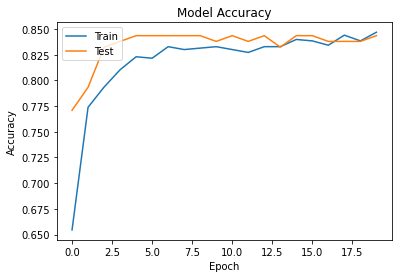

In [41]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('Model Accuracy');
plt.ylabel('Accuracy');
plt.xlabel('Epoch'); 
plt.legend(['Train', 'Test'], loc='upper left');

In [42]:
# Using GridSearch to determine the best parameters and best train score (commented out to save computing resources when executing everything)
'''
param_grid = {'qt_relu_layers': [2, 4, 16, 32, 64, 128],
            'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
            'epochs': [2, 5, 10, 20, 30, 40, 50, 100]
}

model = KerasClassifier(build_fn=get_model, verbose=False, batch_size=batch_size)

use_all_processors = -1
gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=use_all_processors)
                                                  
gs.fit(X_train, y_train_arr)

print(gs.best_params_)
print(gs.best_score_)
'''

"\nparam_grid = {'qt_relu_layers': [2, 4, 16, 32, 64, 128],\n            'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],\n            'epochs': [2, 5, 10, 20, 30, 40, 50, 100]\n}\n\nmodel = KerasClassifier(build_fn=get_model, verbose=False, batch_size=batch_size)\n\nuse_all_processors = -1\ngs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=use_all_processors)\n                                                  \ngs.fit(X_train, y_train_arr)\n\nprint(gs.best_params_)\nprint(gs.best_score_)\n"

# Step 4: Training and evaluating the model that uses the best parameters found on the Grid Search

In [43]:
qt_relu_layers = 128
epochs = 100
optimizer = 'Adam'
model = get_model(qt_relu_layers, optimizer, epochs)
history = model.fit(X_train_std, y_train_arr,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=False,
                    validation_data=(X_test_std, y_test_arr))
score = model.evaluate(X_test_std, y_test_arr, verbose=0)
print('-----------------------------------------------------')
print('Test set loss:', score[0])
print('Test set accuracy:', score[1])
print('Test set F1 score:', score[2])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               4352      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________
-----------------------------------------------------
Test set loss: 0.4210466742515564
Test set accuracy: 0.832402229309082
Test set F1 score: 0.8366227149963379


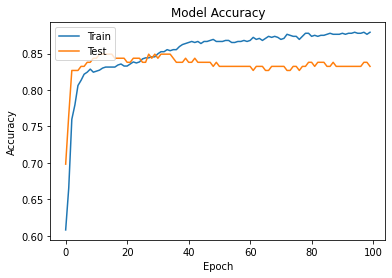

In [44]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('Model Accuracy');
plt.ylabel('Accuracy');
plt.xlabel('Epoch'); 
plt.legend(['Train', 'Test'], loc='upper left');

In [45]:
print("Confusion Matrix for the Test Data:")
y_test_arg = np.argmax(y_test_arr, axis=1)
y_pred = np.argmax(model.predict(X_test_std), axis=1)
print(confusion_matrix(y_test_arg, y_pred))

Confusion Matrix for the Test Data:
[[100  10]
 [ 20  49]]


# Step 5: Applying the model to the validation dataset

In [46]:
df_val = pd.read_csv('Data/validation.csv')

In [47]:
df_val['Family'] = df_val['Name'].str.split(',').str.get(0)
df_val['Entitlement'] = df_val['Name'].str.split(',').str.get(1).str.split(' ').str.get(1)

In [48]:
df_family = df_val[['Family', 'Name']].groupby('Family').size().reset_index(name='FamilySize')
df_val = pd.merge(df_val, df_family, on='Family', how='left')

In [49]:
# Removing the 'Name' and the 'Family' columns now as they became unnecessary
df_val.drop('Name', axis=1, inplace=True)
df_val.drop('Family', axis=1, inplace=True)

In [50]:
df_val[['SibSp', 'Parch', 'FamilySize','PassengerId']].groupby(['SibSp', 'Parch', 'FamilySize']).count().head()

PassengerId
SibSp Parch FamilySize             
0     0     1                   219
            2                    27
            3                     1
            4                     6
      1     1                    10

In [51]:
df_val['FamilyCategory'] = np.select(
    [
        (df_val['SibSp'] == 1) & (df_val['Parch'] == 0), 
        (df_val['SibSp'] == 0) & (df_val['Parch'] == 1),
        (df_val['SibSp'] > 1 )& (df_val['Parch'] == 0),
        (df_val['SibSp'] == 0) & (df_val['Parch'] > 1),
        (df_val['SibSp'] == 0) & (df_val['Parch'] == 0) & (df_val['FamilySize'] != 1),
        (df_val['SibSp'] == 0) & (df_val['Parch'] == 0) & (df_val['FamilySize'] == 1)
    ], 
    [
        'Couple', 
        'Couple',
        'Couple and Children',
        'Couple and Children',
        'Relatives',
        'Single person'
    ], 
    default='Single person' # defaulting to 'Single Person' as most people were by themselves
)

In [52]:
df_val.loc[~df_val['Age'].isna()].groupby('FamilyCategory').median()['Age']

FamilyCategory
Couple                 30.0
Couple and Children    27.5
Relatives              24.0
Single person          27.5
Name: Age, dtype: float64

In [53]:
df_val.loc[df_val.FamilyCategory.eq('Couple') & df_val.Age.isna()] = df_val.loc[df_val.FamilyCategory.eq('Couple') & df_val.Age.isna()].fillna(30);
df_val.loc[df_val.FamilyCategory.eq('Couple and Children') & df_val.Age.isna()] = df_val.loc[df_val.FamilyCategory.eq('Couple and Children') & df_val.Age.isna()].fillna(27);
df_val.loc[df_val.FamilyCategory.eq('Relatives') & df_val.Age.isna()] = df_val.loc[df_val.FamilyCategory.eq('Relatives') & df_val.Age.isna()].fillna(24);
df_val.loc[df_val.FamilyCategory.eq('Single person') & df_val.Age.isna()] = df_val.loc[df_val.FamilyCategory.eq('Single person') & df_val.Age.isna()].fillna(27);

In [54]:
df_val.drop('Cabin', axis=1, inplace=True)

In [55]:
df_val.drop('Ticket', axis=1, inplace=True)

In [56]:
df_val = pd.get_dummies(df_val)

In [57]:
df_val.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Embarked_C,...,Entitlement_Master.,Entitlement_Miss.,Entitlement_Mr.,Entitlement_Mrs.,Entitlement_Ms.,Entitlement_Rev.,FamilyCategory_Couple,FamilyCategory_Couple and Children,FamilyCategory_Relatives,FamilyCategory_Single person
0,892,3,34.5,0,0,7.8292,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,893,3,47.0,1,0,7.0000,1,1,0,0,...,0,0,0,1,0,0,1,0,0,0
2,894,2,62.0,0,0,9.6875,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,895,3,27.0,0,0,8.6625,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,896,3,22.0,1,1,12.2875,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [58]:
df_val['Entitlement_Capt.'] = 0
df_val['Entitlement_Don.'] = 0
df_val['Entitlement_Mlle.'] = 0
df_val['Entitlement_Mme.'] = 0
df_val['Entitlement_Jonkheer.'] = 0
df_val['Entitlement_Lady.'] = 0
df_val['Entitlement_Major.'] = 0
df_val['Entitlement_Sir.'] = 0

In [59]:
X_val = df_val

In [60]:
sc = StandardScaler()
sc.fit(X_val)
X_val_std = sc.transform(X_val)

In [61]:
sc.fit(X)
X_std = sc.transform(X)
y_arr = keras.utils.np_utils.to_categorical(y, num_classes)

In [62]:
# Using GridSearch to determine the best parameters and best train score (commented out to save computing resources when executing everything)
'''
param_grid = {
  'qt_relu_layers': [2, 4, 16, 32, 64, 128],
  'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
  'epochs': [2, 5, 10, 20, 30, 40, 50, 100]
}

model = KerasClassifier(build_fn=get_model, verbose=False, batch_size=batch_size, epochs=epochs)

use_all_processors = -1
gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=use_all_processors)
                                                  
gs.fit(X_std, y_arr)

print(gs.best_params_)
print(gs.best_score_)
'''

"\nparam_grid = {\n  'qt_relu_layers': [2, 4, 16, 32, 64, 128],\n  'optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],\n  'epochs': [2, 5, 10, 20, 30, 40, 50, 100]\n}\n\nmodel = KerasClassifier(build_fn=get_model, verbose=False, batch_size=batch_size, epochs=epochs)\n\nuse_all_processors = -1\ngs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=use_all_processors)\n                                                  \ngs.fit(X_std, y_arr)\n\nprint(gs.best_params_)\nprint(gs.best_score_)\n"

In [63]:
# Training our model with the best NN
qt_relu_layers = 128
optimizer = 'Adam'
epochs = 20
model = get_model(qt_relu_layers, optimizer, epochs)
model.fit(X_std, y_arr,
            batch_size=batch_size,
            epochs=epochs,
            verbose=False
        )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               4352      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________


In [64]:
y_pred = model.predict(X_val_std)

In [65]:
y_pred = np.argmax(y_pred, axis=1)

In [66]:
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['Survived']

In [67]:
df_results = pd.concat([X_val['PassengerId'], y_pred], axis=1)

In [68]:
df_results.to_csv('Results.csv', index=False)